In [1]:
## Kind of working version with 3 unknown cells (outputs something, but has some errors in the output values) 

from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt

## Helper Functions
from helper_functions import *

In [ ]:
## Outline:

# For a 2^2 * 2^2 Sudoku, we will implement a quantum oracle that marks conflicts in the rows and columns of the Sudoku grid. 
# The oracle will use qubits to represent the cells and ancillas to mark conflicts.
# 1. Define a function to mark equality of two qubits.
# 2. Define a function to mark conflicts in a set of cells using the previous function.
# 3. Define a function to apply the oracle to the Sudoku grid, which marks the conflicts using the previous function.
# 4. Apply the diffuser.
# 5. Repeat the oracle and diffuser for a number of iterations.
# 6. Measure the probabilities of the variable qubits to find the most probable solutions.
# 7. Plot the probabilities of the variable qubits.
# 8. Print the most probable solutions.

In [2]:
## TODO: User Input
## Known cells (fixed values)
known_cells = {
    0: 2, 1: 0, 2: 1, 3: 3,
    4: 1, 5: 3, 6: 2, 7: 0,
    8: 0, 9: 1, 10: 3, 
    12: 3
}

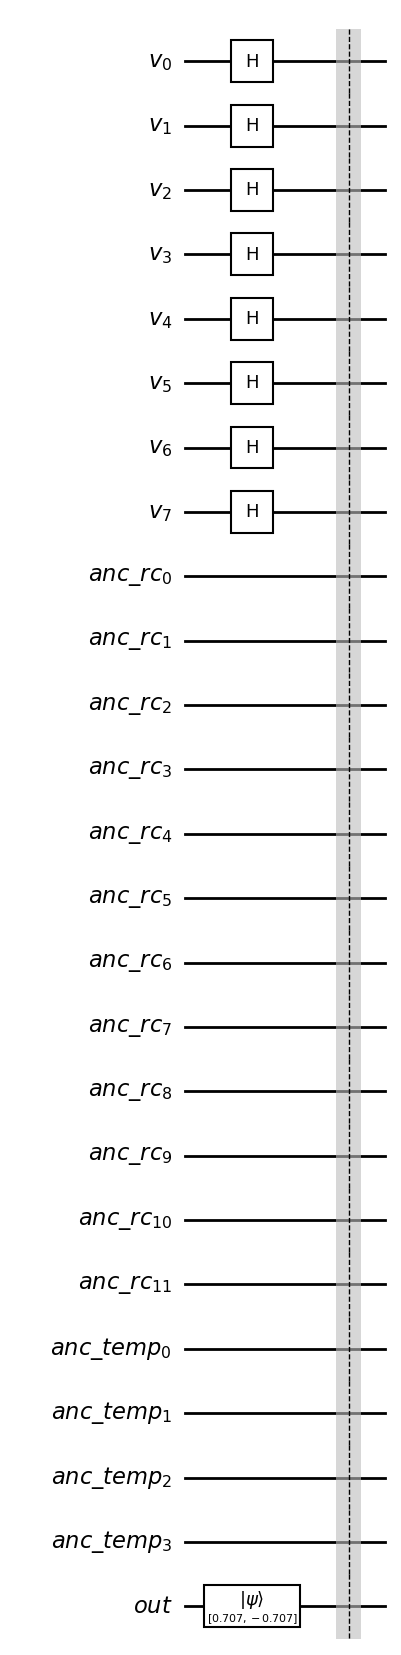

In [ ]:
# Quantum Circuit Setup 

unknown_cells = [i for i in range(16) if i not in known_cells.keys()]  # Unknown cells

# Reduced RC groups for constraints (for testing with given known cells above)
#rcs = [
#    [8,9,10,11], [1,5,9,13], [2,6,10,14], [3,7,11,15]
#]

# RCS: Row/Column/Square Constraints (takes  a long time to run with all constraints)
rcs = [
    [0,1,2,3], [4,5,6,7], [8,9,10,11], [12,13,14,15],
    [0,4,8,12], [1,5,9,13], [2,6,10,14], [3,7,11,15],
    [0,1,4,5], [2,3,6,7], [8,9,12,13], [10,11,14,15]
]

num_vars = 2 * len(unknown_cells)  
var_qubits = QuantumRegister(num_vars, 'v')
rc_ancillas = AncillaRegister(len(rcs), 'anc_rc')  # ancillas for each RC group
temp_ancillas = AncillaRegister(4, 'anc_temp')  # temp ancillas
output = QuantumRegister(1, 'out') # output qubit for marking conflicts

qc = QuantumCircuit(var_qubits, rc_ancillas, temp_ancillas, output)

# Initialize superposition on variable qubits
qc.initialize([1, -1]/np.sqrt(2), output)
qc.h(var_qubits)
qc.barrier()

qc.draw(output="mpl", style="bw")


In [ ]:
# Apply Grover iterations
N = 4**len(unknown_cells)  
num_iterations = 10#int(np.floor(np.pi/4 * np.sqrt(N)))  

for _ in range(num_iterations):
    apply_oracle(qc, known_cells, var_qubits, output, rc_ancillas, temp_ancillas, rcs)
    qc.append(diffuser(len(var_qubits)), var_qubits[:])

# Final statevector and probabilities
final_state = Statevector.from_instruction(qc)
probs = final_state.probabilities(qargs=range(num_vars))  # indices of var_qubits

# Plotting Histogram of probabilities
num_var_qubits = len(var_qubits)
labels = [format(i, f'0{num_var_qubits}b') for i in range(2**num_var_qubits)]
plt.bar(labels, probs)
plt.xlabel('Binary State (var_qubits)')
plt.ylabel('Probability')
plt.title('Measurement Probabilities')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# Get labels and probabilities together
labeled_probs = list(zip(labels, probs))

# Sort by probability descending
labeled_probs.sort(key=lambda x: x[1], reverse=True)

# Print top results
print("Most probable bitstrings (variable qubits only):")
for label, prob in labeled_probs:
    if prob > 1e-3:
        print(f"{label} → {prob:.4f}")


Most probable bitstrings (variable qubits only):
10001011 → 0.4845
01001011 → 0.4845
